# Attempting to measure the accuracy of volatility indexs
This notebook will look at how to quantify the effectiveness of a calculated index for any point in time. As these indexs are forward looking the performance of a security over the year following the date of observation will be taken.

In [2]:
%load_ext autoreload
%autoreload 2

import metrics_calc
import vix_calc
import sqlite3
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta

In [3]:
conn = sqlite3.connect("../data_aggregation/flow_database.db")
conn.row_factory = vix_calc.my_row_factory
cursor = conn.cursor()

In [4]:
DT = '2021-12-31'

d = datetime.strptime(DT, '%Y-%m-%d')
# (d + timedelta(days=365)).strftime('%Y-%m-%d')

In [5]:
def query_spy(DT):
    d = datetime.strptime(DT, '%Y-%m-%d')
    for_dt = (d + timedelta(days=365)).strftime('%Y-%m-%d')
    query = f"""
    select
        open,
        close,
        date_of,
        date_of_close
    from price_data

    where symbol = 'SPY'
    and date_of_close >= '{DT}'
    and date_of_close <= '{for_dt}'
    ;
    """

    cursor.execute(query)
    data = cursor.fetchall()
    data = pd.DataFrame.from_records(data)
    
    data['date_of_close'] = data.date_of_close.apply(pd.to_datetime)
    data['annual_'] = (data.date_of_close - d).dt.days / 365
    
    return data

def observe_vix_acc(DT):
    VIX = vix_calc.main(DT)
    data = query_spy(DT)
    start_close = data.iloc[0].close
    
    data['vix_t'] = data.annual_.apply(lambda x: vix_calc.get_period_volatility(VIX, x))
    
    data['price_up'] = (data.vix_t / 100 + 1) * start_close
    data['price_down'] = (-data.vix_t / 100 + 1) * start_close
    return (data, VIX)

In [6]:
data, vix = observe_vix_acc(DT)
data.head(4)

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down
0,472.06,474.96,2021-12-27,2021-12-31,0.000000,0.000000,474.960000,474.960000
1,476.30,466.09,2022-01-03,2022-01-07,0.019178,2.286795,485.821362,464.098638
2,462.70,464.72,2022-01-10,2022-01-14,0.038356,3.234017,490.320286,459.599714
3,459.74,437.98,2022-01-17,2022-01-21,0.057534,3.960845,493.772431,456.147569


In [7]:
data.vix_t.sum()

579.4472049772746

## A look at implied volatilty as prescribed by the vix over a period of time

16.512950255801464


<AxesSubplot: xlabel='date_of_close'>

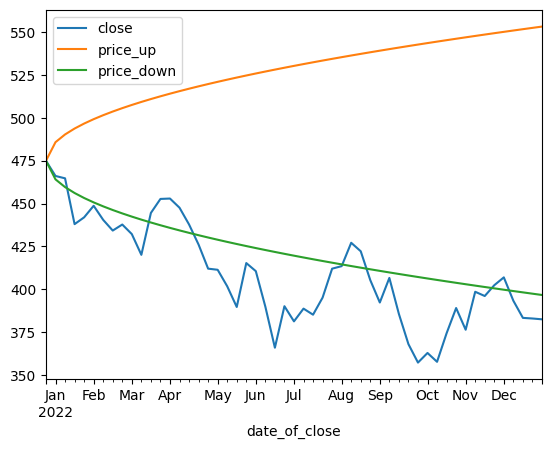

In [8]:
data, VIX = observe_vix_acc(DT)
print(VIX)
data.plot(x='date_of_close', y=['close', 'price_up', 'price_down'])

## A look at the absolute change in the SPY (to date), and the prescribed volatility bound

In [13]:
data

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down
0,472.060,474.96,2021-12-27,2021-12-31,0.000000,0.000000,474.960000,474.960000
1,476.300,466.09,2022-01-03,2022-01-07,0.019178,2.286795,485.821362,464.098638
2,462.700,464.72,2022-01-10,2022-01-14,0.038356,3.234017,490.320286,459.599714
3,459.740,437.98,2022-01-17,2022-01-21,0.057534,3.960845,493.772431,456.147569
4,432.030,441.95,2022-01-24,2022-01-28,0.076712,4.573590,496.682724,453.237276
5,441.240,448.70,2022-01-31,2022-02-04,0.095890,5.113429,499.246744,450.673256
6,449.510,440.46,2022-02-07,2022-02-11,0.115068,5.601481,501.564795,448.355205
7,439.920,434.23,2022-02-14,2022-02-18,0.134247,6.050291,503.696463,446.223537
8,431.890,437.75,2022-02-21,2022-02-25,0.153425,6.468033,505.680571,444.239429
9,432.030,432.17,2022-02-28,2022-03-04,0.172603,6.860385,507.544087,442.375913


In [41]:
vix * 2/3

11.008633503867642

In [28]:
((data.iloc[:52].vix_t).sum() / 16.490314) / 52

0.6565123048737012

In [34]:
(data.iloc[:53].vix_t).sum()

579.4472049772746

Text(0, 0.5, 'Absolute change since first period')

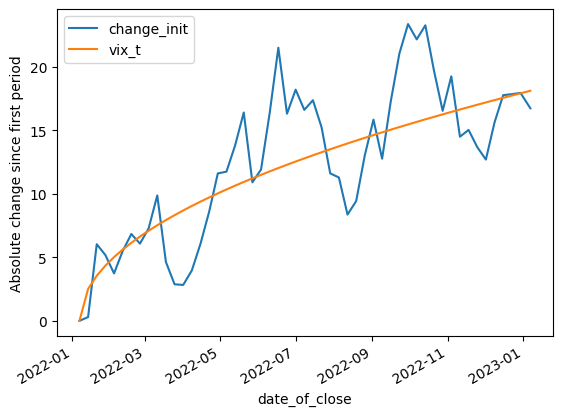

In [129]:
data['change_init'] = abs(data.close / data.close.iloc[0] - 1) * 100
ax = data.plot(x='date_of_close', y=['change_init', 'vix_t'])
ax.set_ylabel('Absolute change since first period')

## 3 ways of measuring effectiveness for a individual period
1. Count how frequently the SPY leaves the vix bounds
3. Compare Index to the standard deviation of the stocks proven performance
2. Take the difference between the area under the curve for both indexs.

In [130]:
df.head()

,close,date_of_close,vix_t,change_init
0,437.98,2022-01-21,0.000000,0.000000
1,441.95,2022-01-28,3.768618,0.906434
2,448.70,2022-02-04,5.329630,2.447600
3,440.46,2022-02-11,6.527437,0.566236
4,434.23,2022-02-18,7.537235,0.856203


#### Simple Accuracy

In [131]:
df = data[['close', 'date_of_close', 'vix_t', 'change_init']].copy()

# within, exceeded = df.bounded.value_counts().loc[True], df.bounded.value_counts().loc[False]
within, exceeded = metrics_calc.calc_accuracy(df, real_col='change_init')
print('Within Bound:\t', within)
print('Exceeded bound:\t', exceeded)
print('Accuracy: ', round(within/(within+exceeded)*100, 2))

Within Bound:	 24
Exceeded bound:	 29
Accuracy:  45.28


#### Standard Deviation
Note: As the standard deviation is an annualised value, for any given point, the difference between the VIX and the STD for the following year can be compared.

In [132]:
df.close.std()

28.372731765507627

In [133]:
print('Standard Deviation:\t\t', df.close.std())
print('Relative Standard Deviation:\t', df.close.std() / df.close.mean() * 100)

Standard Deviation:		 28.372731765507627
Relative Standard Deviation:	 6.960094122722693


## Area Under the curve

In [136]:
df.change_init.std()

6.087393371560778

In [106]:
data.vix_t.sum() - data.change_init.sum()

528.0267615239161

In [107]:
data['curve_diff'] = data.vix_t - data.change_init

In [113]:
metrics_calc.calc_auc(data, real_col='change_init', vix_t='vix_t')

(528.0267615239163, 0.0)

In [108]:
data[data.curve_diff > 0].curve_diff.sum()

528.0267615239163

In [110]:
data.head()

,open,close,date_of,date_of_close,annual_,vix_t,price_up,price_down,change_init,curve_diff
0,459.74,437.98,2022-01-17,2022-01-21,0.000000,0.000000,437.980000,437.980000,0.000000,0.000000
1,432.03,441.95,2022-01-24,2022-01-28,0.019178,3.768618,454.485792,421.474208,0.906434,2.862184
2,441.24,448.70,2022-01-31,2022-02-04,0.038356,5.329630,461.322714,414.637286,2.447600,2.882030
3,449.51,440.46,2022-02-07,2022-02-11,0.057534,6.527437,466.568870,409.391130,0.566236,5.961201
4,439.92,434.23,2022-02-14,2022-02-18,0.076712,7.537235,470.991583,404.968417,0.856203,6.681032
